# Data Exploration
The main point of this is to estimate how quickly the environment changes, to get a better sense of what latency we can permit on our end.
However, it's also just good to see what kind of data others are getting, what the data we might get will be like, etc...

## Imports

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Dataset Creation

In [102]:
df = pd.read_csv("Data/loon-flights-2021Q2.csv")
df = df.sort_values(['flight_id', 'time'])
df.head()

,flight_id,time,latitude,longitude,altitude,temperature,pressure,earth_ir,earth_ir_sensor_config,acs,propeller_on,velocity_u,velocity_v,omega,acceleration,solar_elevation,solar_azimuth,is_daytime
0,LN-191,2021-04-01T00:00:15.000Z,-24.667770,67.734242,17670.9,195.26,81.25,287.81,3,0,0,0.259,-3.145,0.0002,0.0065,-22.922669,95.718685,0
1,LN-191,2021-04-01T00:01:15.000Z,-24.669518,67.734419,17675.7,195.23,81.19,285.84,3,0,0,-0.065,-3.327,0.0000,0.0084,-22.696175,95.605274,0
2,LN-191,2021-04-01T00:02:08.000Z,-24.671161,67.734289,17674.9,195.22,81.20,286.05,3,0,0,-0.412,-3.478,0.0000,0.0084,-22.496322,95.505494,0
3,LN-191,2021-04-01T00:02:15.000Z,-24.671383,67.734262,17674.9,195.24,81.23,286.32,3,0,0,-0.453,-3.507,0.0001,0.0083,-22.469932,95.492338,0
4,LN-191,2021-04-01T00:03:16.000Z,-24.673406,67.733811,17677.5,195.25,81.15,285.21,3,0,0,-0.804,-3.635,0.0003,0.0065,-22.240131,95.377981,0


## Data Cleaning
Lets figure out what to do with NaN values, and make the time value into something usable.

## General Info
We can see some NA values in Altitude, Temperature, Earth IR Temperature, and the Velocity.
The velocity is set to NaN when the propeller is on, but I'm not sure why others are not.

The temperature range seems quite useful to know for checking our instrument's valid termerature ranges!

In [104]:
print(f"Number of NaN Values: \n{df.isna().sum()}")

print(f"\nGeneral Info:\n {df.describe()}")

Number of NaN Values: 
flight_id                    0
time                         0
latitude                     0
longitude                    0
altitude                   177
temperature                582
pressure                     0
earth_ir                   510
earth_ir_sensor_config       0
acs                          0
propeller_on                 0
velocity_u                1129
velocity_v                1129
omega                        0
acceleration                 0
solar_elevation              0
solar_azimuth                0
is_daytime                   0
dtype: int64

General Info:
             latitude      longitude       altitude    temperature  \
count  826541.000000  826541.000000  826364.000000  825959.000000   
mean      -16.749956      68.605055   17975.872304     201.584474   
std        10.084508      45.150697    1061.485006       7.205131   
min       -52.706985    -179.997847     162.600000     185.520000   
25%       -20.951450      63.017115   17269.0

In [103]:
df["time"] = pd.to_datetime(df['time'], utc=True)
print(df["time"].head())

0   2021-04-01 00:00:15+00:00
1   2021-04-01 00:01:15+00:00
2   2021-04-01 00:02:08+00:00
3   2021-04-01 00:02:15+00:00
4   2021-04-01 00:03:16+00:00
Name: time, dtype: datetime64[ns, UTC]


## Histograms
Only performed on the values it makes sense to look at in a histogram.

### Sensor Data

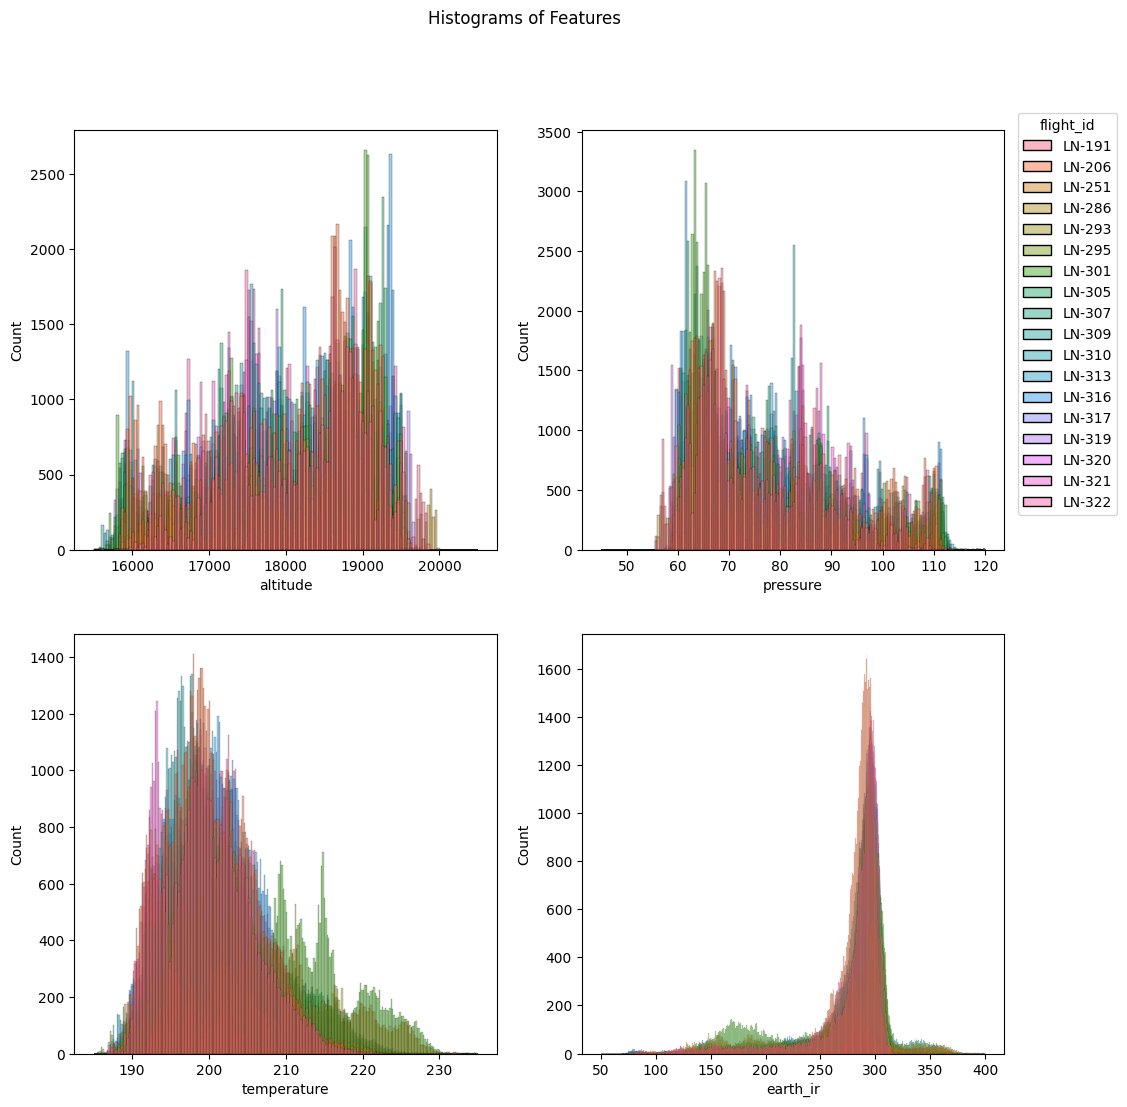

In [6]:
# Keep track of the featurs to graph and the min/max bins they should use
features = {"altitude": (15500, 20500), "pressure": (45, 120), "temperature": (185, 235), "earth_ir": (50, 400)}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(right=0.9)

# Graph all the features
for feature, axis in zip(features, axes.flatten()):
    bin_range = features[feature]
    sns.histplot(df, x=feature, hue="flight_id", alpha=0.5, binrange=bin_range, ax=axis)

# Multi-Plot Legend Cleanup
legend = axes[0,0].get_legend()
fig.add_artist(legend)
legend.set_bbox_to_anchor((1.0, 0.9), transform=fig.transFigure)
for axis in axes.flatten():
    legend = axis.get_legend()
    if legend:
        legend.remove()

fig.suptitle("Histograms of Features")
plt.show()

### Motion

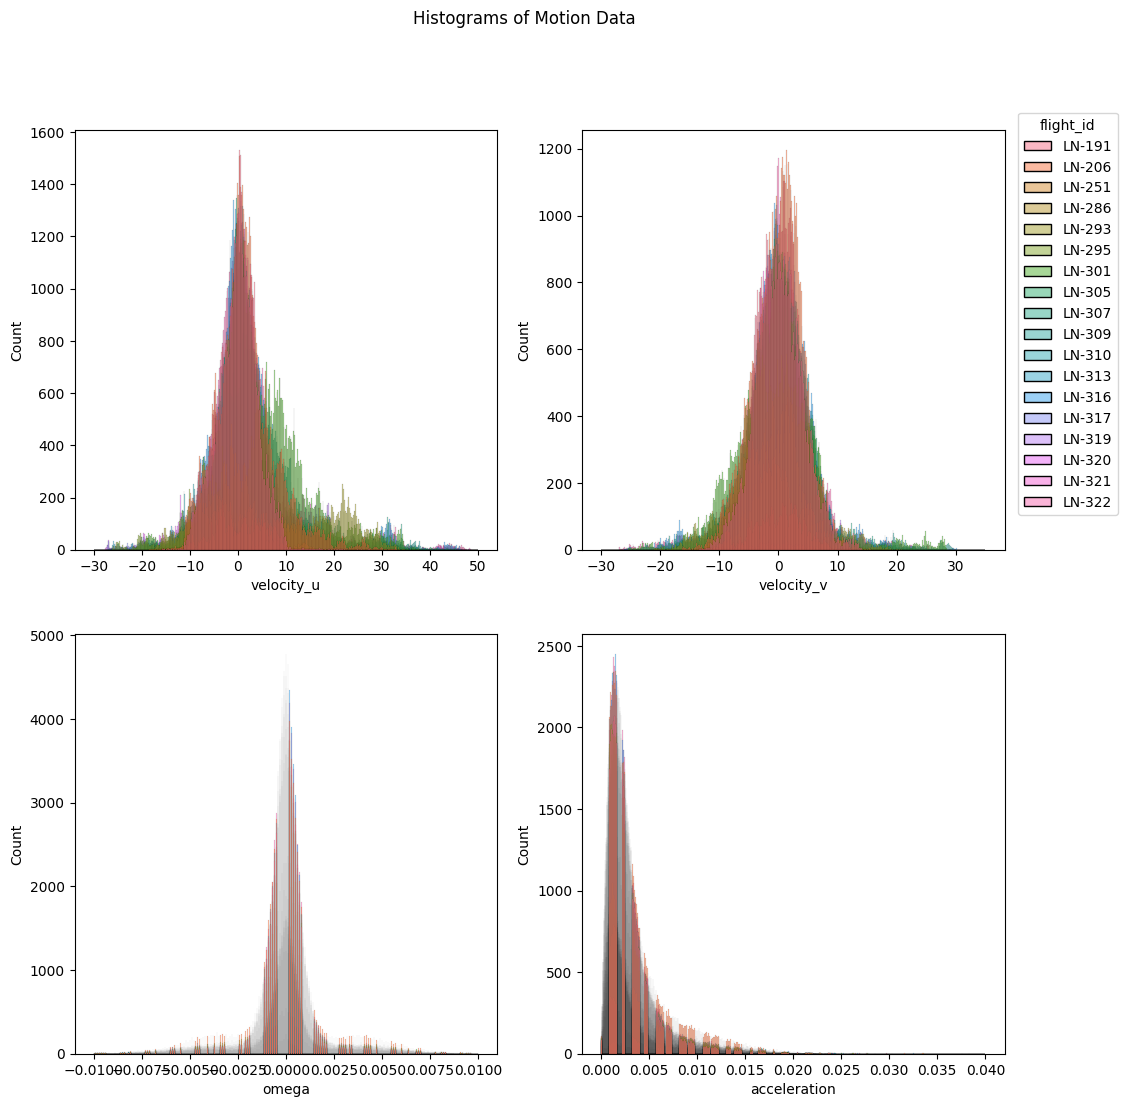

In [7]:
# Keep track of the featurs to graph and the min/max bins they should use
features = {"velocity_u": (-30, 50), "velocity_v": (-30, 35), "omega": (-0.01, 0.01), "acceleration": (0, 0.04)}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(right=0.9)

# Graph all the features
for feature, axis in zip(features, axes.flatten()):
    bin_range = features[feature]
    sns.histplot(df, x=feature, hue="flight_id", alpha=0.5, binrange=bin_range, ax=axis)

# Multi-Plot Legend Cleanup
legend = axes[0,0].get_legend()
fig.add_artist(legend)
legend.set_bbox_to_anchor((1.0, 0.9), transform=fig.transFigure)
for axis in axes.flatten():
    legend = axis.get_legend()
    if legend:
        legend.remove()

fig.suptitle("Histograms of Motion Data")
plt.show()

## Correlation
It's useful to look at which elements have correlations between one another, as it can help us discover strange behaviors we were unaware of, and potentially issues with our measurements.

- Here we can see that pressure and elevation are strongly inversely correalted, as expected. 
- Similarly, altitude and temperature are also somwhat correlated as we'd expect.
- We also see correlation between temperature and the EarthIR readings (the IR temperature of the earth, I think), which makes sense.
- It is less expected that the Velocity U (velocity west to east) is inversly correlated with altitude, pressure, and temperature readings. It makes sense that if you correlate with one, you do so with all, but it's unexpected that we see those correlated with only one dimension of velocity. It must be related to where they are taking their measurements.
- We see a little correlation between temperature and solar elevation. This is also pretty expected!
- In a surprise to no-one, there is a near-exact correlation between solar elevation and if it is daytime. 

Nothing too strange, but worth doing for our data to verify our expectations, and we can use this as a baseline!

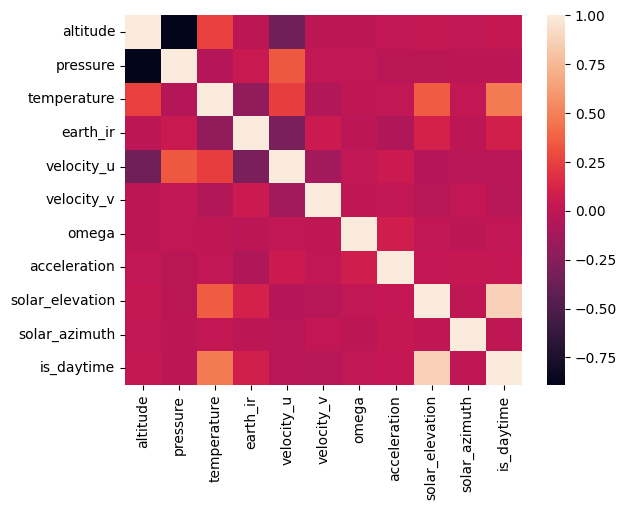

In [8]:
sns.heatmap(df[["altitude", "pressure", "temperature", "earth_ir", "velocity_u", "velocity_v", "omega", "acceleration", "solar_elevation", "solar_azimuth", "is_daytime"]].corr())

plt.show()

## Change Over Time
Now to find the main information I'm looking for - how quickly these variable change over time. This is important because if our instructions to the balloon are sent too infrequently compared to how fast the environment changes, then we're going to have a lot of trouble controlling it!

### Values Over Time

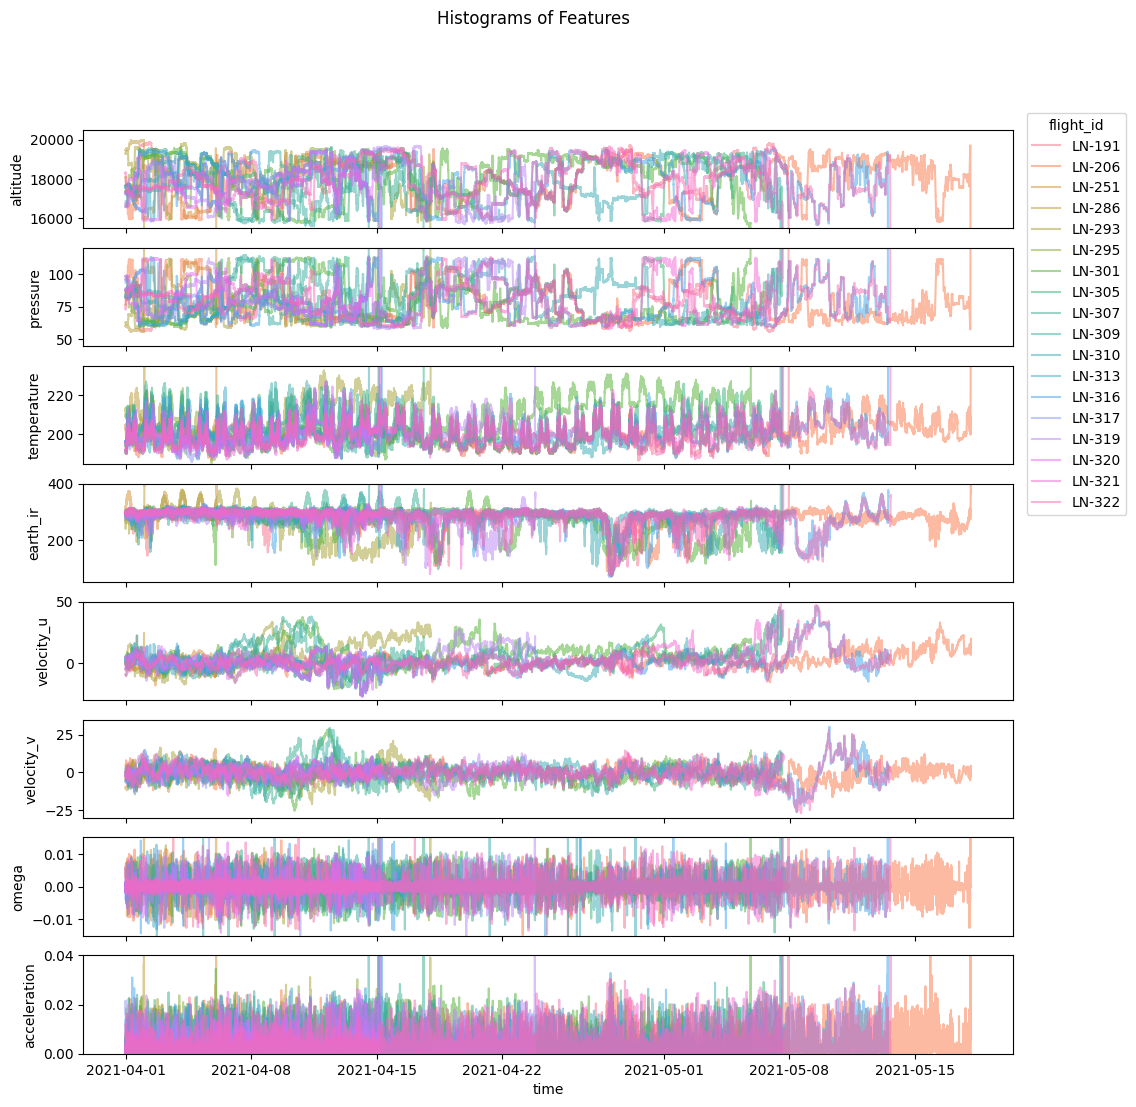

In [ ]:
# Keep track of the featurs to graph and the min/max bins they should use
features = {"altitude": (15500, 20500), "pressure": (45, 120), "temperature": (185, 235), "earth_ir": (50, 400), "velocity_u": (-30, 50), "velocity_v": (-30, 35), "omega": (-0.015, 0.015), "acceleration": (0, 0.04)}

fig, axes = plt.subplots(len(features), 1, figsize=(12, 12))
plt.subplots_adjust(right=0.9)

# Graph all the features
for idx, (feature, axis) in enumerate(zip(features, axes.flatten())):

    sns.lineplot(df, x="time", y=feature, hue="flight_id", alpha=0.5, ax=axis)
    ylim = features[feature]
    axis.set_ylim(ylim)

    if idx != (len(features)-1):
        axis.set_xlabel("")
        axis.set_xticklabels([])

# Multi-Plot Legend Cleanup
legend = axes[0].get_legend()
fig.add_artist(legend)
legend.set_bbox_to_anchor((1.0, 0.9), transform=fig.transFigure)
for axis in axes.flatten():
    legend = axis.get_legend()
    if legend:
        legend.remove()

fig.suptitle("Features over Time")
plt.show()

### Deltas Over Time

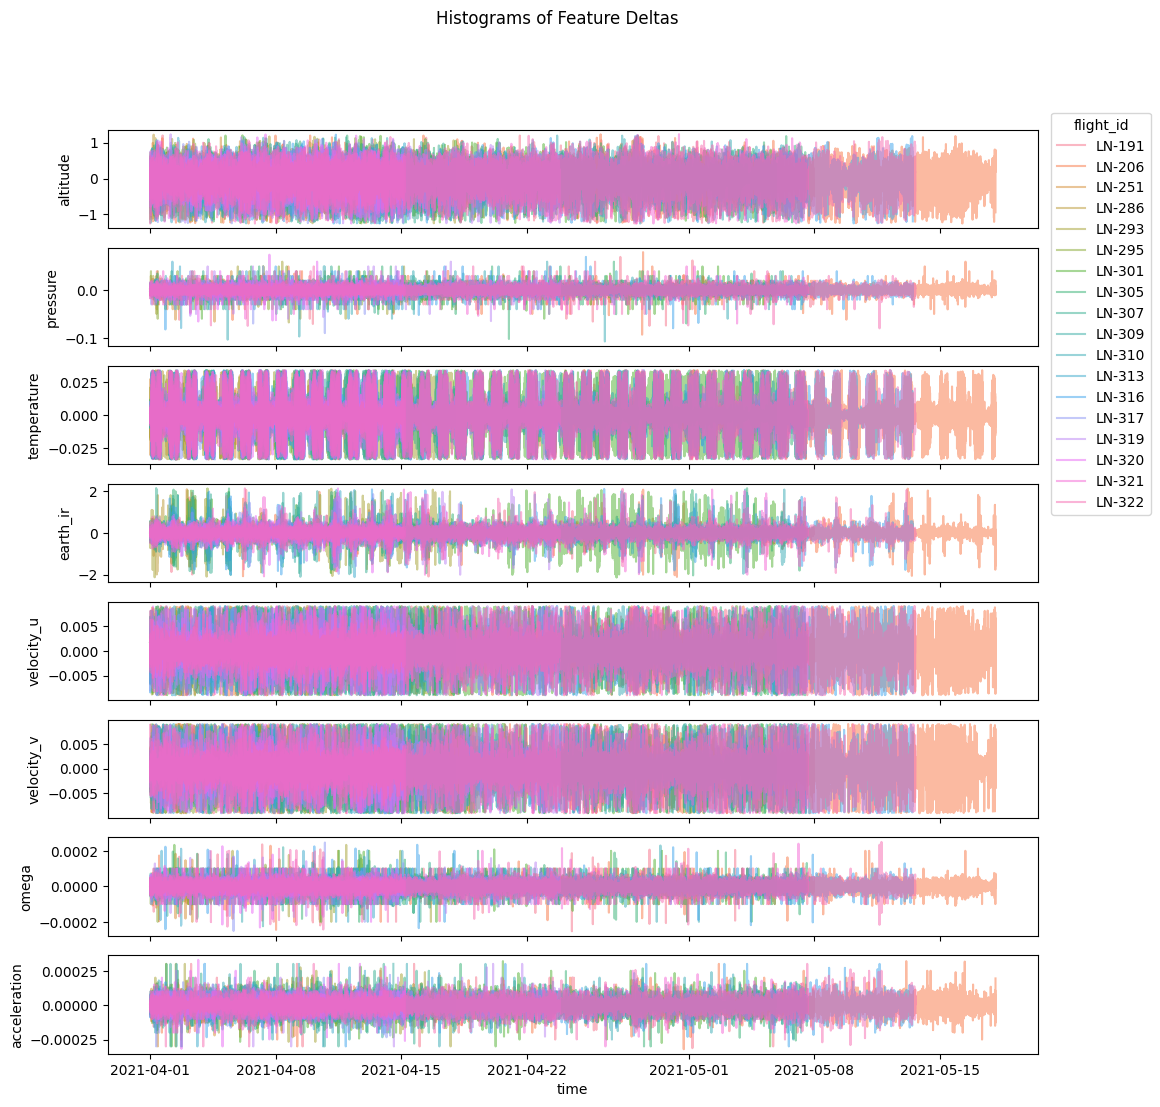

In [ ]:
# Keep track of the featurs to graph and the min/max bins they should use
features = {"altitude": (15500, 20500), "pressure": (45, 120), "temperature": (185, 235), "earth_ir": (50, 400), "velocity_u": (-30, 50), "velocity_v": (-30, 35), "omega": (-0.015, 0.015), "acceleration": (0, 0.04)}

# Find the deltas of each flight
df_diff_grouped = df.groupby('flight_id', as_index=False)
df_diffs = df_diff_grouped[["time"] + [feature for feature in features]].diff()
df_diffs = df_diffs.loc[:, df_diffs.columns != "time"].div(df_diffs["time"].dt.total_seconds(), axis=0)

# Exclude the most extreme outliers - they're probably invalid
df_diffs = df_diffs[(np.abs(stats.zscore(df_diffs.loc[:, df_diffs.columns != "time"], nan_policy="omit")) < 3).all(axis=1)]
df_diffs["time"] = df["time"]
df_diffs["flight_id"] = df["flight_id"]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 12))
plt.subplots_adjust(right=0.9)

# Graph all the features
for idx, (feature, axis) in enumerate(zip(features, axes.flatten())):

    sns.lineplot(df_diffs.iloc[1:, :], x="time", y=feature, hue="flight_id", alpha=0.5, ax=axis)
    ylim = features[feature]
    axis.set_ylabel(feature)
    #axis.set_ylim(ylim)

    if idx != (len(features)-1):
        axis.set_xlabel("")
        axis.set_xticklabels([])

# Multi-Plot Legend Cleanup
legend = axes[0].get_legend()
fig.add_artist(legend)
legend.set_bbox_to_anchor((1.0, 0.9), transform=fig.transFigure)
for axis in axes.flatten():
    legend = axis.get_legend()
    if legend:
        legend.remove()

fig.suptitle("Feature Deltas Over Time")
plt.show()